In [1]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
import qpoint as qp
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import time

In [2]:
t0 = 1640991600
qpo = qp.QPoint()
ra0, dec0, _, _ = qpo.azel2radec(0,0,0, [100], [55], [0.], [0.], [-67.786], [-22.958], [t0])

scan_opts = dict(ra0=[ra0], dec0=[dec0], az_throw=360, scan_speed=2, 
                 el_min=50, cut_el_min=True, check_interval=3600)
mlen        = 60*6      # Minute made
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60


In [3]:
#sky
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt', unpack=True)
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
sky_alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) 

scan_sky = ScanStrategy(duration=mlen,sample_rate=50.01, location='atacama', ctime0 = t0)
scan_sky.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_sky.allocate_maps(nside=512)
scan_sky.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_sky.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_sky.set_hwp_mod(mode='continuous', freq=1.)
scan_sky.scan_instrument_mpi(sky_alm, save_tod=True, **scan_opts)

Scanning with 18 detectors
[rank 000]: working on: Det00A, Det00B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det01A, Det01B


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det02A, Det02B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det10A, Det10B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det11A, Det11B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det12A, Det12B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det20A, Det20B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det21A, Det21B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det22A, Det22B
[rank 000]:	Working on chunk 000: samples 0-18003


In [4]:
#geometric ground
theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)))
ground = np.zeros(hp.nside2npix(512))
ground[theta>(np.pi/2-np.pi/12.*np.sin(12*phi))]=3.5e8#horizon condition
ground = hp.smoothing(ground, fwhm=np.pi/180.)
sine_alm = hp.map2alm([hp.smoothing(ground, fwhm=np.pi/180.), 
                         np.zeros_like(ground), np.zeros_like(ground)], lmax = 700)

scan_sine = ScanStrategy(duration=mlen,sample_rate=50.01, location='atacama', ctime0 = t0)
scan_sine.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_sine.allocate_maps(nside=512)
scan_sine.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_sine.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_sine.set_hwp_mod(mode='continuous', freq=1.)
scan_sine.scan_instrument_mpi(sky_alm, ground_alm=sine_alm, save_tod=True, **scan_opts)

/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 25.479654 arcmin (0.007412 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 60.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


Scanning with 18 detectors
[rank 000]: working on: Det00A, Det00B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det01A, Det01B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det02A, Det02B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det10A, Det10B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det11A, Det11B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det12A, Det12B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det20A, Det20B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det21A, Det21B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det22A, Det22B
[rank 000]:	Working on chunk 000: samples 0-18003


In [5]:
#atacama ground
gata = hp.smoothing(hp.read_map('./ancillary/ground_ata95.fits'), fwhm=np.pi/180.)
cerro_alm = hp.map2alm([gata, np.zeros_like(gata), np.zeros_like(gata)], lmax = 700)

scan_atac = ScanStrategy(duration=mlen,sample_rate=50.01, location='atacama', ctime0 = t0)
scan_atac.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_atac.allocate_maps(nside=512)
scan_atac.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_atac.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_atac.set_hwp_mod(mode='continuous', freq=1.)
scan_atac.scan_instrument_mpi(sky_alm, ground_alm=cerro_alm, save_tod=True, **scan_opts)

/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Scanning with 18 detectors
[rank 000]: working on: Det00A, Det00B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det01A, Det01B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det02A, Det02B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det10A, Det10B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det11A, Det11B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det12A, Det12B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det20A, Det20B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det21A, Det21B
[rank 000]:	Working on chunk 000: samples 0-18003
[rank 000]: working on: Det22A, Det22B
[rank 000]:	Working on chunk 000: samples 0-18003


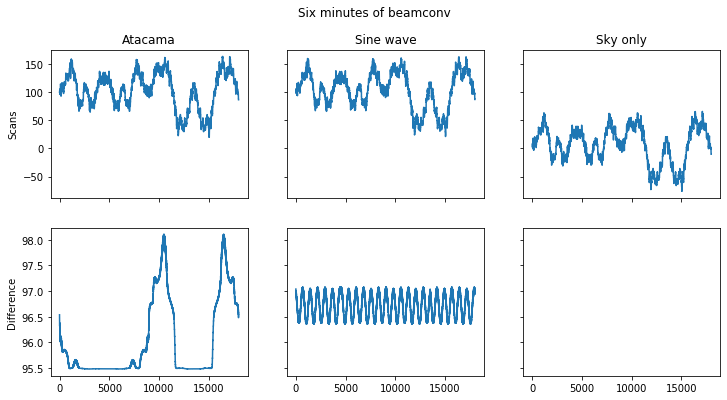

In [6]:
scan_atac_center = scan_atac._data['0']['8']['tod']
scan_sine_center = scan_sine._data['0']['8']['tod']
scan_sky_center = scan_sky._data['0']['8']['tod']
fig, ax = plt.subplots(2,3, sharex=True, sharey='row', figsize=(12,6))
ax[0,0].plot(scan_atac_center)
ax[0,1].plot(scan_sine_center)
ax[0,2].plot(scan_sky_center)
ax[1,0].plot(scan_atac_center - scan_sky_center)
ax[1,1].plot(scan_sine_center - scan_sky_center)
ax[0,0].set_ylabel("Scans")
ax[1,0].set_ylabel("Difference")
ax[0,0].set_title("Atacama")
ax[0,1].set_title("Sine wave")
ax[0,2].set_title("Sky only")
fig.suptitle("Six minutes of beamconv")
plt.savefig("ssn53elev")

In [7]:
nsamp = int(mlen*50.01)
sine_az = np.empty(nsamp, dtype=np.float64)
sine_el = np.empty(nsamp, dtype=np.float64)
scan_sine.bore2radec(np.array([1,0,0,0]), scan_sine.ctime, scan_sine.q_boreground, ra=sine_az, dec=sine_el)
atac_az = np.empty(nsamp, dtype=np.float64)
atac_el = np.empty(nsamp, dtype=np.float64)
scan_atac.bore2radec(np.array([1,0,0,0]), scan_atac.ctime, scan_atac.q_boreground, ra=atac_az, dec=atac_el)

(array([ 99.99999963, 100.03999163, 100.07998364, ...,  99.85602843,
         99.89602043,  99.93601243]),
 array([51.00000029, 51.00000029, 51.00000029, ..., 51.00000029,
        51.00000029, 51.00000029]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]))

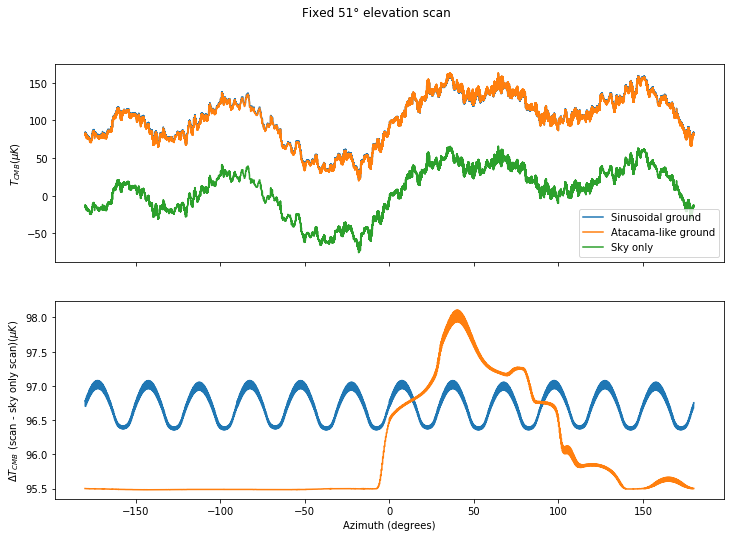

In [8]:
fig, ax = plt.subplots(2, sharex=True, sharey='row', figsize=(12,8))
az_arg = np.argsort(sine_az)
ax[0].plot(sine_az[az_arg], scan_sine_center[az_arg])
ax[0].plot(atac_az[az_arg], scan_atac_center[az_arg])
ax[0].plot(sine_az[az_arg], scan_sky_center[az_arg])
ax[1].plot(sine_az[az_arg], scan_sine_center[az_arg] - scan_sky_center[az_arg])
ax[1].plot(atac_az[az_arg], scan_atac_center[az_arg] - scan_sky_center[az_arg])
ax[0].legend(["Sinusoidal ground", "Atacama-like ground", "Sky only"])
ax[0].set_ylabel(r"$T_{CMB}(\mu K)$")
ax[1].set_ylabel(r"$\Delta T_{CMB}$ (scan - sky only scan)$(\mu K)$")
ax[1].set_xlabel("Azimuth (degrees)")
fig.suptitle("Fixed 51° elevation scan ")
plt.savefig("ssn51.png", transparent=True)

In [73]:
#maps
mlen=24*60*60*7
scan_opts = dict(ra0=[ra0], dec0=[dec0], az_throw=70, scan_speed=1, 
                 el_min=50, cut_el_min=True, check_interval=600)
scan_sky = ScanStrategy(duration=mlen,sample_rate=5.1, location='atacama', ctime0 = t0)
scan_sky.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_sky.allocate_maps(nside=512)
scan_sky.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_sky.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_sky.set_hwp_mod(mode='continuous', freq=1.)
scan_sky.scan_instrument_mpi(sky_alm, binning=True, **scan_opts)

scan_atac = ScanStrategy(duration=mlen,sample_rate=5.1, location='atacama', ctime0 = t0)
scan_atac.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_atac.allocate_maps(nside=512)
scan_atac.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_atac.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_atac.set_hwp_mod(mode='continuous', freq=1.)
scan_atac.scan_instrument_mpi(sky_alm, ground_alm=cerro_alm, binning=True, **scan_opts)

scan_sine = ScanStrategy(duration=mlen,sample_rate=5.1, location='atacama', ctime0 = t0)
scan_sine.load_focal_plane('./ancillary/ssn_beams', no_pairs=True, combine=False)
scan_sine.allocate_maps(nside=512)
scan_sine.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
scan_sine.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
scan_sine.set_hwp_mod(mode='continuous', freq=1.)
scan_sine.scan_instrument_mpi(sky_alm, ground_alm=sine_alm, binning=True, **scan_opts)

Scanning with 18 detectors
[rank 000]: working on: Det00A, Det00B
[rank 000]:	Working on chunk 000: samples 0-3084480


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |
/Users/personal/.local/lib/python3.7/site-packages/beamconv-0.1-py3.7.egg/beamconv/instrument.py:2259: RuntimeWarning: Cutting el min
  warn('Cutting el min', RuntimeWarning)


[rank 000]: working on: Det01A, Det01B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det02A, Det02B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det10A, Det10B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det11A, Det11B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det12A, Det12B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det20A, Det20B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det21A, Det21B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det22A, Det22B
[rank 000]:	Working on chunk 000: samples 0-3084480
Scanning with 18 detectors
[rank 000]: working on: Det00A, Det00B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det01A, Det01B
[rank 000]:	Working on chunk 000: samples 0-3084480
[rank 000]: working on: Det02A, Det02B
[rank 000]:	Working on c

In [74]:
sky_map, sky_cond = scan_sky.solve_for_map()
atac_map, atac_cond = scan_atac.solve_for_map()
sine_map, sine_cond = scan_sine.solve_for_map()

<Figure size 432x288 with 0 Axes>

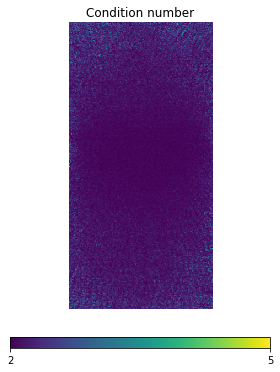

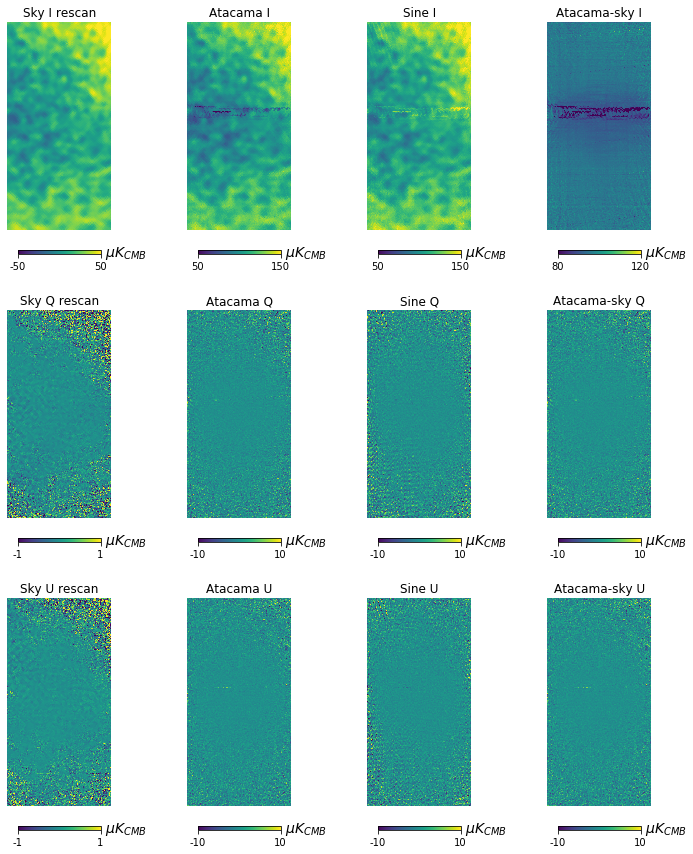

In [80]:
cartopts =  {'lonra':[50, 65], 'latra':[-40,-10], 'fig':1, 'unit':r'$\mu K_{CMB}$'}
fig2 = plt.figure(2)
hp.cartview(sky_cond, title='Condition number', min=2, max=5, lonra=[50, 65], latra=[-40,-10])
fig1 = plt.figure(1, figsize=(10,12))

hp.cartview(sky_map[0], title='Sky I rescan', min=-50, max=50, sub=[3,4,1], **cartopts)
hp.cartview(sky_map[1], title='Sky Q rescan', min=-1, max=1, sub=[3,4,5], **cartopts)
hp.cartview(sky_map[2], title='Sky U rescan', min=-1, max=1, sub=[3,4,9], **cartopts)


hp.cartview(atac_map[0], title='Atacama I', min=50, max=150, sub=[3,4,2], **cartopts)
hp.cartview(atac_map[1], title='Atacama Q', min=-10, max=10, sub=[3,4,6], **cartopts)
hp.cartview(atac_map[2], title='Atacama U', min=-10, max=10, sub=[3,4,10], **cartopts)

hp.cartview(sine_map[0], title='Sine I', min=50, max=150, sub=[3,4,3], **cartopts)
hp.cartview(sine_map[1], title='Sine Q', min=-10, max=10, sub=[3,4,7], **cartopts)
hp.cartview(sine_map[2], title='Sine U', min=-10, max=10, sub=[3,4,11], **cartopts)

hp.cartview(atac_map[0]-sky_map[0], title='Atacama-sky I', min=80, max=120, sub=[3,4,4], **cartopts)
hp.cartview(atac_map[1]-sky_map[1], title='Atacama-sky Q', min=-10, max=10, sub=[3,4,8], **cartopts)
hp.cartview(atac_map[2]-sky_map[2], title='Atacama-sky U', min=-10, max=10, sub=[3,4,12], **cartopts)